In [38]:
import numpy as np
from scipy.linalg import solve_continuous_lyapunov
from scipy.optimize import minimize
from scipy.stats import multivariate_normal

## Simulation

### Setting
We look at $X(t)\in \mathbb{R}^5$, meaning $p=5$, choose any $k\in \{1,2,3,4\}$ and set $d = k/p$ as the edge probability, and define mean and standard deviation for the normal distribution.

We choose to intervene on the first node, so $A={1}$.

For every choice of matrices $M$ and $C$, we will generate $N=1000$ samples of the normal distribution, that solves the Lyapunov equation.

In [40]:
p = 5
k = 1
d = k / p
mean = 0
mean_vector = np.zeros(p)
sd = 1
intervention_set = [0]
intervention_value = [3]
N = 1000

### Model drift matrix
We model the drift matrix $M$ by setting $m_{ij}=\omega_{ij}\varepsilon_{ij}$ for $i\neq j$ and the diagonal to $m_{ii}=-\sum_{j\neq i}\lvert m_{ij}\rvert - \lvert\varepsilon_{ii}\rvert$ with $\omega_{ij}\sim \text{Bernoulli}(d)$ and $\varepsilon_{ij}\sim \mathcal{N}(0,1)$.

In [24]:
np.random.seed(1208)
bernoulli_matrix = np.random.binomial(1, d, (p, p))
normal_matrix = np.random.normal(mean, sd, (p, p))
M = bernoulli_matrix * normal_matrix
for i in range(p):
    row_sum = np.sum(np.abs(M[i, :])) - np.abs(M[i, i])
    M[i, i] = - row_sum - np.abs(normal_matrix[i,i])


### Fix volatility matrix
Choose $C=2*I_p$.

In [25]:
C = 2 * np.identity(p)

### Solve the Lyapunov equation
Find the matrix $\Sigma$ that solves the Lyapunov equation
$$M \Sigma + \Sigma M^\top + C = 0.$$
***Attention:*** the algorithm solves the equation $M \Sigma + \Sigma M^\top = C$ so we need the negative matrix $-C$.

In [29]:
Sigma = solve_continuous_lyapunov(M, - C)

### Create simulated data
Generate $N=1000$ observations of a $p$-dimensional normal distribution with mean $0$ and covariance matrix $\Sigma$.

In [30]:
np.random.seed(1208)
obs = np.random.multivariate_normal(mean = mean_vector, cov = Sigma, size = (N, p))

## Estimation

Apply the Direct Lyapunov Lasso with $C = 2I_p$
$$\min_{M\in\mathbb{R}^{p x p}} \frac{1}{2}\lvert\lvert M \Sigma + \Sigma M^\top + C\rvert\rvert^2_F + \lambda \lvert\lvert M \rvert\rvert _1$$
with tuning parameter $\lambda >0$ to estimate the matrix $M$.

In [37]:
lambda_val = 0.1

def dll_objective(M_flat, Sigma, C, lambda_val, p) -> float:
    M = M_flat.reshape((p, p))
    frobenius_norm = 0.5 * np.linalg.norm(M @ Sigma + Sigma @ M.T + C, ord = 'fro') ** 2
    l1_norm = np.sum(np.abs(M))
    return frobenius_norm + lambda_val * l1_norm

initial_M = - np.eye(p, p).flatten()

result = minimize(dll_objective, initial_M, args=(Sigma, C, lambda_val, p), method='L-BFGS-B')
M_optimized = result.x.reshape((p, p))
print("Optimized M matrix:\n", M_optimized)
print("Objective function value:", result.fun)

Optimized M matrix:
 [[-2.52409569e+00 -1.09286092e-01 -1.00579715e-01 -9.75390365e-01
   1.89575041e-08]
 [-3.58913772e-08 -4.73793618e-01 -6.02544348e-08 -9.88159796e-08
   5.72808707e-10]
 [ 1.55075365e-09 -5.20588830e-02 -1.16758702e+00 -2.39869689e-08
   1.21600291e-01]
 [-2.10671641e-01  6.56049098e-01  1.22445565e+00 -2.95201110e+00
   4.21979991e-08]
 [ 3.43283033e-08  1.67226089e-05  1.94299250e-01  2.41587404e-08
  -1.15631449e+00]]
Objective function value: 1.32638995336986


## Simulation of interventional data

To generate samles from interventional data we need to sample from the conditional distribution. When we intervene on a subset $A\subset [p]$ and set all the components to $X_A=x_A$, then we need to sample the rest of the vector $X_{-A}$ according to the conditional distribution with

$$X_{-A}\mid X_A=x_A \sim \mathscr{N}(\mu_{-A} + \Sigma_{-A,A}\Sigma_{A,A}^{-1}(x_A-\mu_A), \Sigma_{-A,-A} - \Sigma_{-A,A}\Sigma_{A,A}^{-1}\Sigma_{A,-A}).$$

This procedure is done exemplary in the next code snippet (ChatGPT). Here, we call $-A$, the indices not in $A$, $B$.

In [44]:
# Partition the mean and covariance
mean_vector_A = mean_vector[intervention_set]
mean_vector_B = np.delete(mean_vector, intervention_set)
Sigma_AA = Sigma[np.ix_(intervention_set, intervention_set)]
Sigma_AB = Sigma[np.ix_(intervention_set, [i for i in range(p) if i not in intervention_set])]
Sigma_BA = Sigma[np.ix_([i for i in range(p) if i not in intervention_set], intervention_set)]
Sigma_BB = Sigma[np.ix_([i for i in range(p) if i not in intervention_set], [i for i in range(p) if i not in intervention_set])]

# Compute the conditional mean and covariance for X_B | X_A = x_A
conditional_mean = mean_vector_B + Sigma_BA @ np.linalg.inv(Sigma_AA) @ (intervention_value - mean_vector_A)
conditional_cov = Sigma_BB - Sigma_BA @ np.linalg.inv(Sigma_AA) @ Sigma_AB

# Sample X_B from the conditional distribution
np.random.seed(1208)
x_B = multivariate_normal.rvs(mean=conditional_mean, cov=conditional_cov)
# x_B = np.random.multivariate_normal(mean = conditional_mean, cov = conditional_cov, size = (N, p-len(intervention_set)))

# Combine X_A = x_A with the sampled x_B to get the full vector X
x_interventional = np.empty(p)
x_interventional[intervention_set] = intervention_value
x_interventional[[i for i in range(p) if i not in intervention_set]] = x_B

# Print the result
print("Interventional Sample:")
print(x_interventional)


Interventional Sample:
[ 3.         -2.478136   -0.14824914 -1.66732523  0.11513092]


In [49]:
from sympy import *
from sympy.solvers import solve
init_printing(use_unicode=True)

In [79]:
p = 2
M = Matrix([[-5, 4], [3, -5]])
C = diag(p, p)
 
#matr = MatrixSymbol("Sigma", p, p)
#Sigma = Matrix(p, p, lambda i, j: matr[min(i,j),max(i,j)])

Sigma = MatrixSymbol("Sigma", p, p).as_explicit()
Sigma_solved = solve(M*Sigma + Sigma*M.T + C, Sigma)

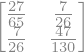

In [85]:
Sigma_solved
Sigma_new = Matrix([[Sigma_solved[Sigma[0, 0]], Sigma_solved[Sigma[0, 1]]], [Sigma_solved[Sigma[1, 0]], Sigma_solved[Sigma[1, 1]]]])
Sigma_new

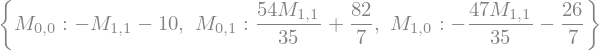

In [86]:
M = MatrixSymbol("M", p, p).as_explicit()
solve(M*Sigma_new + Sigma_new*M.T + C, M)